# Predicting Housing Prices
In this projects, we are going to build a model that will predict housing prices based on a number of features.
We will build the model on housing data from Ames, Iowa from 2006 to 2010. The dataset was compiled for an article published in the Journal of Statistics Education: https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627

## Data Exploration

In [1]:
# import pandas, matplotlib, seaborn, and numpy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [2]:
# read in our data
housing = pd.read_csv('AmesHousing.tsv', sep='\t')

# look at first few rows to get a feel for the data
housing.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

## Basic model

In [4]:
def transform_features(df):
    return df

def select_features(df):
    cols = ['Gr Liv Area','SalePrice']
    return df[cols]

# function train_and_test separates the data into training and testing sets
# Then, trains a linear regression model on the trainind data using numerical
# columns to predict SalePrice. Tests the model on the test set and returns the
# RMSE value for the model
def train_and_test(df):
    
    # Split data in half
    train_last_row = 1460
    train = df.head(1460)
    test = df.tail(len(df)-1460)
    
    # Get list of features
    features = train.columns.drop('SalePrice')
    
    # Import LinearRegression and mean_squared error from sklearn
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    
    # Instantiate and fit model
    lr = LinearRegression()
    lr.fit(train[features], train['SalePrice'])
    
    # Generate predictions and return RMSE
    labels = lr.predict(test[features])
    return mean_squared_error(test['SalePrice'], labels)**(1/2)

transform_housing = transform_features(housing)
filtered_housing = select_features(transform_housing)
rmse = train_and_test(filtered_housing)

rmse

57088.25161263909

## Feature Engineering
To start, we want to apply several key modifications to our data:
- Remove columns missing more than 5% of their data
- Remove text columns missing any data
- Fill missing values in numerical columns with the mode of the column

In [5]:
# Remove columns missing more than 5% of their data
housing = housing.dropna(axis=1, thresh = .95 * len(housing))

# Remove text columns missing any data
text_cols = housing.select_dtypes(include='object').columns.tolist()
for col in text_cols:
    if housing[col].isnull().sum() > 0:
        housing = housing.drop(col, axis=1)

# Fill missing values in numeric columns with the mode
numeric_cols = housing.select_dtypes(include=['int64','float64']).columns.tolist()
for col in numeric_cols:
    mode = housing[col].dropna().mode()
    housing[col] = housing[col].fillna(mode[0])

# Verify there are no missing values
housing.isnull().sum().value_counts()

0    64
dtype: int64

Let's see what new features we can generate by consolidating existing features.
For example, the Year Sold and Year Built columns are most relevant with respect to each other for predicting sale price, so we can combine them for our model.

In [6]:
# compute the age of the house at sale
age_at_sale = housing['Yr Sold'] - housing['Year Built']

# check if there are any errors here
age_at_sale[age_at_sale < 0]

2180   -1
dtype: int64

Let's also compute the years since the last addition or remodel and the sale.

In [7]:
# compute time since last remodel at sale
years_since_remod = housing['Yr Sold'] - housing['Year Remod/Add']

# check if there are any errors
years_since_remod[years_since_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

Let's replace the old features with our two new features and remove the rows with date errors.

In [8]:
# generate two new columns with our new features
housing['Age At Sale'] = age_at_sale
housing['Yrs Since Remod'] = years_since_remod

# remove original features
housing = housing.drop(['Yr Sold','Year Built','Year Remod/Add'], axis=1)

# Drop rows with negative values for our new features
#housing = housing.drop([2180,1702,2180,2181], axis=0)
housing = housing[housing['Age At Sale'] >= 0]
housing = housing[housing['Yrs Since Remod'] >= 0]

Now, we can sort through and drop columns that are not useful to machine learning. These include PID and Order. Let's also remove columns which leak information about the sale, including the month of the sale, the sale condition, and the sale type.

In [9]:
# drop columns not useful to our model
housing = housing.drop(['PID','Order'], axis=1)

# drop columns leaking sale information
housing = housing.drop(['Mo Sold','Sale Condition','Sale Type'], axis=1)

Let's update our transform_features function to reflect our feature engineering workflow:

In [10]:
def transform_features(df):
    
    # Remove columns missing more than 5% of their data
    df = df.dropna(axis=1, thresh = .95 * len(df))

    # Remove text columns missing any data
    text_cols = df.select_dtypes(include='object').columns.tolist()
    for col in text_cols:
        if df[col].isnull().sum() > 0:
            df = df.drop(col, axis=1)

    # Fill missing values in numeric columns with the mode
    numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
    for col in numeric_cols:
        mode = df[col].dropna().mode()
        df[col] = housing[col].fillna(mode[0])
        
    # compute the age of the house at sale
    age_at_sale = df['Yr Sold'] - df['Year Built']
    
    # compute time since last remodel at sale
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    
    # generate two new columns with our new features
    df['Age At Sale'] = age_at_sale
    df['Yrs Since Remod'] = years_since_remod

    # remove original features
    df = df.drop(['Yr Sold','Year Built','Year Remod/Add'], axis=1)

    # Drop rows with negative values for our new features
    df = df[df['Age At Sale'] >= 0]
    df = df[df['Yrs Since Remod']>=0]
    
    # drop columns not useful to our model
    df = df.drop(['PID','Order'], axis=1)

    # drop columns leaking sale information
    df = df.drop(['Mo Sold','Sale Condition','Sale Type'], axis=1)
        
    return df

def select_features(df):
    cols = ['Gr Liv Area','SalePrice']
    return df[cols]

# function train_and_test separates the data into training and testing sets
# Then, trains a linear regression model on the trainind data using numerical
# columns to predict SalePrice. Tests the model on the test set and returns the
# RMSE value for the model
def train_and_test(df):
    
    # Split data in half
    train_last_row = 1460
    train = df.head(1460)
    test = df.tail(len(df)-1460)
    
    # Get list of features
    features = train.columns.drop('SalePrice')
    
    # Import LinearRegression and mean_squared error from sklearn
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    
    # Instantiate and fit model
    lr = LinearRegression()
    lr.fit(train[features], train['SalePrice'])
    
    # Generate predictions and return RMSE
    labels = lr.predict(test[features])
    return mean_squared_error(test['SalePrice'], labels)**(1/2)

housing = pd.read_csv('AmesHousing.tsv', sep='\t')
transform_housing = transform_features(housing)
filtered_housing = select_features(transform_housing)
rmse = train_and_test(filtered_housing)

rmse

55275.36731241307

## Feature Selection
Now that we have cleaned and transformed many of the features in the set, we now need to determine which features we will use for our regression. To start, we need to determine which relevant variables need to be converted to categorical. Then, we need to filter our numeric variables based on relevancy for machine learning.

### Categorical Variables
To use categorical variables in a regression model, we need to use "dummy coding," where we transform each categorical column into a number of columns, each representing one unique value from the original feature. Good candidates for dummy coding should have:
- An appropriate number of unique values: too many will complicate our data, and too few will not be informative
- An appropriate amoount of variance (not too many values belong in one category).

We also need to consider which features are currently listed as numerical but need to be changed to categorical because the numbers do not have semantic meaning. We can start to identify these by the number of unique values in each numeric column. Let's first look for the numerics we need to change, then filter all our categorical vars by number of unique values.

In [11]:
# initialize dictionary to store number of unique values for each numeric column
num_uniques = {}
numerical_features = transform_housing.select_dtypes(include=['integer','float']).columns
numerical_housing = transform_housing[numerical_features]

# iterate numeric columns
for col in numerical_features:
    num_uniques[col] = len(numerical_housing[col].value_counts())

num_uniques = pd.DataFrame.from_dict(num_uniques, orient='index').sort_values(by=0, ascending=True)
num_uniques

,0
Bsmt Half Bath,3
Half Bath,3
Kitchen AbvGr,4
Bsmt Full Bath,4
Fireplaces,5
Full Bath,5
Garage Cars,6
Bedroom AbvGr,8
Overall Cond,9
Overall Qual,10


Looking at the number of unique values and the documentation, several numeric columns stand out as categorical
- Overall condition
- Overall quality
- MS SubClass

So, we should convert these to categorical. Each of them has only a few values, so we should be okay to dummy code them. we'll save the dummy coding for our final set of categoricals.

In [12]:
# convert selected numeric columns to numeric
numeric_categoricals = ['Overall Cond','Overall Qual', 'MS SubClass']
for col in numeric_categoricals:
    transform_housing[col] = transform_housing[col].astype('category')

Next, let's look at the unique values in our object columns to identify other potential categoricals.

In [13]:
# get non-numeric columns
object_features = transform_housing.select_dtypes(include='object').columns
object_housing = transform_housing[object_features]

# look at unique values
num_uniques = {}

for col in object_features:
    num_uniques[col] = len(object_housing[col].value_counts())
    
num_uniques = pd.DataFrame.from_dict(num_uniques, orient='index').sort_values(by=0, ascending=True)
num_uniques

,0
Central Air,2
Street,2
Land Slope,3
Paved Drive,3
Utilities,3
Lot Shape,4
Exter Qual,4
Land Contour,4
Heating QC,5
Lot Config,5


Looking at our list and the documentation, all these features are candidates for categorical features in our model. Let's convert these columns to categorical. 

Then, we will take all our categorical variables and flag any that have more than 95% of one category. These will have variance that is too low.

In [14]:
# convert object types to categorical
for col in object_features:
    transform_housing[col] = transform_housing[col].astype('category')

In [15]:
# Check out categories for columns where more than 95% of of the values are one category
category_features = transform_housing.select_dtypes(include='category').columns
low_var_features = []

for col in category_features:
        unique_vals = transform_housing[col].value_counts()
        for val in unique_vals:
            if val > .95 * len(transform_housing[col]):
                low_var_features.append(col)
                
low_var_features

['Street', 'Utilities', 'Land Slope', 'Condition 2', 'Roof Matl', 'Heating']

In [16]:
# remove low var features
transform_housing = transform_housing.drop(low_var_features, axis=1)

### Numerical Features
Let's start by looking at a heatmap of the numerical features in order to identify strong correlations with SalePrice and look for redundant variables.

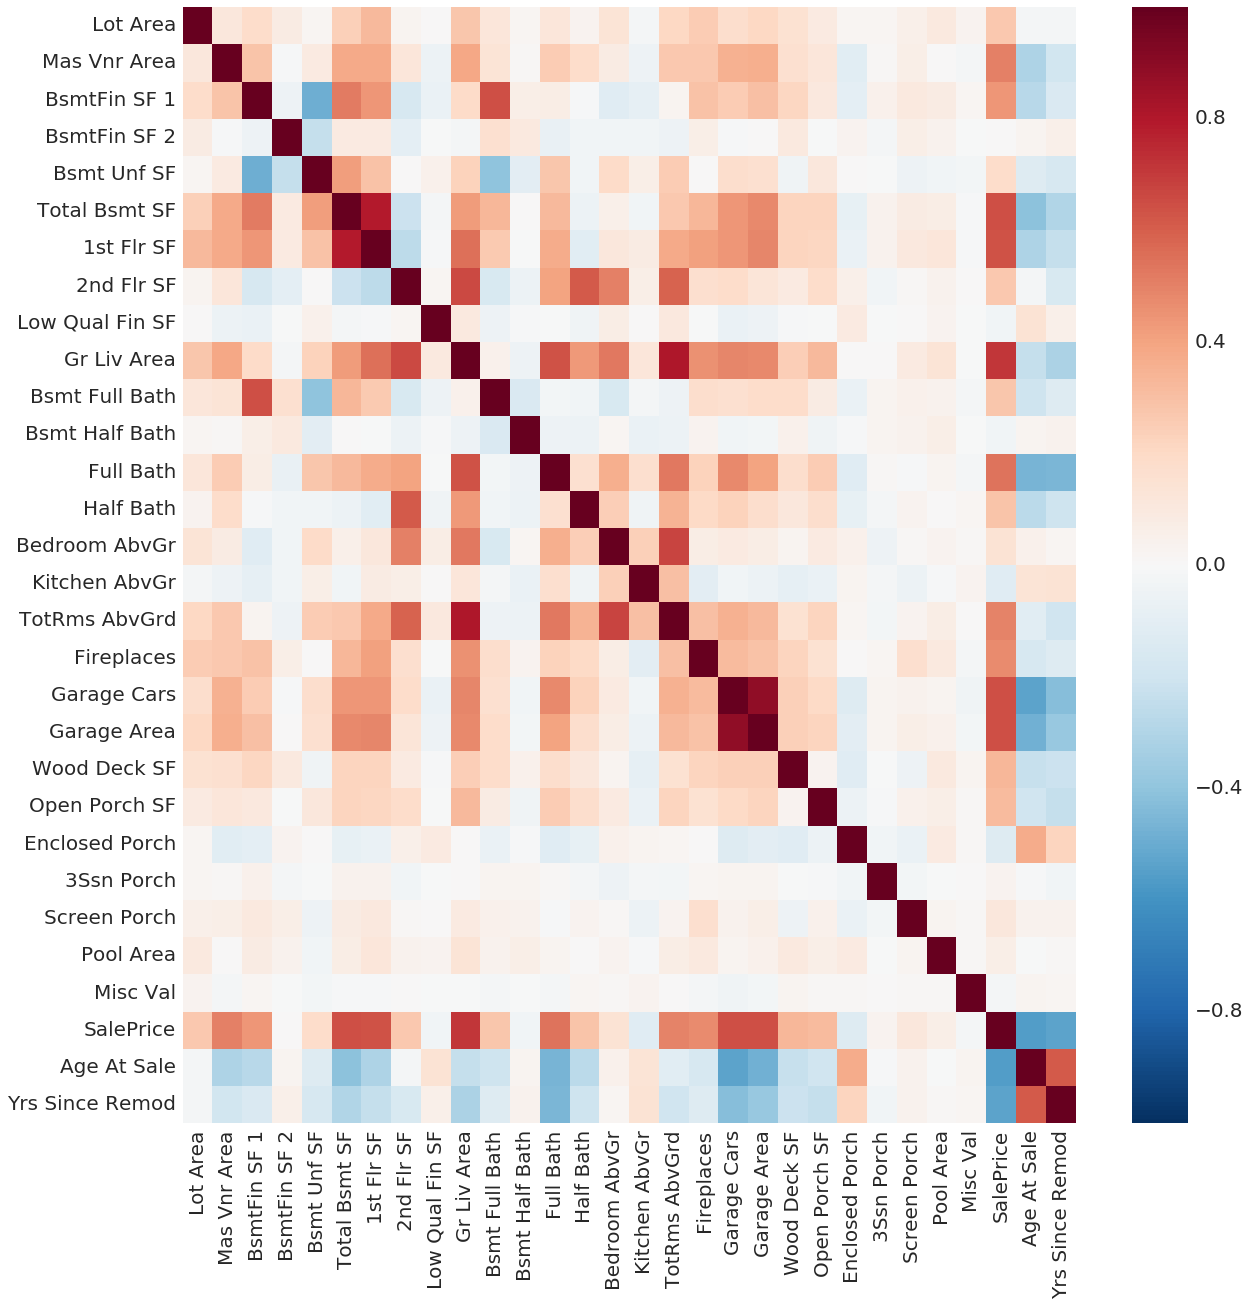

In [17]:
# filter for numeric types
numerical_features = transform_housing.select_dtypes(include=['integer','float']).columns
numerical_housing = transform_housing[numerical_features]

# print heatmap of correlations
corr_data = numerical_housing.corr()
sns.set(font_scale=2)
fig = plt.figure(figsize = [20,20])
sns.heatmap(corr_data)
plt.show()

The heatmap allows us to identify a number of features which correlate strongly with sale price. Let's only keep variables with an absolute correlation with SalePrice of at least 0.4.

In [18]:
# Drop correlations with less than 0.4 
low_corr = corr_data['SalePrice'][corr_data['SalePrice'] < 0.4].index
transform_housing = transform_housing.drop(low_corr, axis=1)

We can also identify three clusters of variables which highly correlate with each other and may convey redundant information:
- Age at Sale and Years since Remodeling
- Garage Cars and Garage Area
- Total Basement Square Footage and Total 1st floor square footage

Of these three sets, we can definitely say that the number of cars you can fit in a garage and its total area are redundant, so we can just stick with the garage area.

In [19]:
# Drop Garage Cars, which is a reduntant column
transform_housing = transform_housing.drop('Garage Cars', axis=1)

### Dummy coding
Now that we have parsed through our relevant features, let's convert the categorical features to dummy-coded features.

In [20]:
# convert each categorical variable into dummy categories
category_features = transform_housing.select_dtypes(include='category').columns
transform_housing = pd.concat([
    transform_housing,
    pd.get_dummies(transform_housing.select_dtypes(include='category'))
], axis=1).drop(category_features,axis=1)

Now, let's update our feature selection function to reflect our changes.

In [21]:
def transform_features(df):
    
    # Remove columns missing more than 5% of their data
    df = df.dropna(axis=1, thresh = .95 * len(df))

    # Remove text columns missing any data
    text_cols = df.select_dtypes(include='object').columns.tolist()
    for col in text_cols:
        if df[col].isnull().sum() > 0:
            df = df.drop(col, axis=1)

    # Fill missing values in numeric columns with the mode
    numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
    for col in numeric_cols:
        mode = df[col].dropna().mode()
        df[col] = housing[col].fillna(mode[0])
        
    # compute the age of the house at sale
    age_at_sale = df['Yr Sold'] - df['Year Built']
    
    # compute time since last remodel at sale
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    
    # generate two new columns with our new features
    df['Age At Sale'] = age_at_sale
    df['Yrs Since Remod'] = years_since_remod

    # remove original features
    df = df.drop(['Yr Sold','Year Built','Year Remod/Add'], axis=1)

    # Drop rows with negative values for our new features
    df = df[df['Age At Sale'] >= 0]
    df = df[df['Yrs Since Remod']>=0]
    
    # drop columns not useful to our model
    df = df.drop(['PID','Order'], axis=1)

    # drop columns leaking sale information
    df = df.drop(['Mo Sold','Sale Condition','Sale Type'], axis=1)
        
    return df

def select_features(df):
    # initialize dictionary to store number of unique values for each numeric column
    num_uniques = {}
    numerical_features = df.select_dtypes(include=['integer','float']).columns
    numerical_housing = df[numerical_features]

    # convert selected numeric columns to numeric
    numeric_categoricals = ['Overall Cond','Overall Qual', 'MS SubClass']
    for col in numeric_categoricals:
        df[col] = df[col].astype('category')

    # get non-numeric columns
    object_features = df.select_dtypes(include='object').columns
    object_housing = df[object_features]

    # convert object types to categorical
    for col in object_features:
        df[col] = df[col].astype('category')

    # Check out categories for columns where more than 95% of of the values are one category
    category_features = df.select_dtypes(include='category').columns
    low_var_features = []

    for col in category_features:
            unique_vals = df[col].value_counts()
            for val in unique_vals:
                if val > .95 * len(df[col]):
                    low_var_features.append(col)

    # remove low var features
    df = df.drop(low_var_features, axis=1)

    # filter for numeric types
    numerical_features = df.select_dtypes(include=['integer','float']).columns
    numerical_housing = df[numerical_features]

    # Drop correlations with less than 0.4 
    corr_data = numerical_housing.corr()
    low_corr = corr_data['SalePrice'][corr_data['SalePrice'] < 0.4].index
    df = df.drop(low_corr, axis=1)

    # Drop Garage Cars, which is a reduntant column
    df = df.drop('Garage Cars', axis=1)

    # convert each categorical variable into dummy categories
    category_features = df.select_dtypes(include='category').columns
    df = pd.concat([
        df,
        pd.get_dummies(df.select_dtypes(include='category'))
    ], axis=1).drop(category_features,axis=1)
    
    return df

# function train_and_test separates the data into training and testing sets
# Then, trains a linear regression model on the trainind data using numerical
# columns to predict SalePrice. Tests the model on the test set and returns the
# RMSE value for the model
def train_and_test(df):
    
    # Split data in half
    train_last_row = 1460
    train = df.head(1460)
    test = df.tail(len(df)-1460)
    
    # Get list of features
    features = train.columns.drop('SalePrice')
    
    # Import LinearRegression and mean_squared error from sklearn
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    
    # Instantiate and fit model
    lr = LinearRegression()
    lr.fit(train[features], train['SalePrice'])
    
    # Generate predictions and return RMSE
    labels = lr.predict(test[features])
    return mean_squared_error(test['SalePrice'], labels)**(1/2)

housing = pd.read_csv('AmesHousing.tsv', sep='\t')
transform_housing = transform_features(housing)
filtered_housing = select_features(transform_housing)
rmse = train_and_test(filtered_housing)

rmse

30584.610989166933

## Cross Validation
Let's add a parameter, k, which modifies the type of cross validation and number of folds used in our model. When k = 0, we use simple holdout validation, training the model on 50% of the data and testing on the other 50%. When k > 0, we implement k-fold cross validation and return the average RMSE.

In [23]:
def train_and_test(df, k=0):
    
    # Import LinearRegression, KFoldm and mean_squared error from sklearn
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error
    
    # Instantiate model
    lr = LinearRegression()
    
    # Get list of features
    features = df.columns.drop('SalePrice')
    
    if k == 0:
        # Split data in half
        train_last_row = 1460
        train = df.head(1460)
        test = df.tail(len(df)-1460)

        # fit model
        lr.fit(train[features], train['SalePrice'])

        # Generate predictions and return RMSE
        labels = lr.predict(test[features])
        return mean_squared_error(test['SalePrice'], labels)**(1/2)
    
    elif k == 1:
        # Randomize all rows
        shuffled_df = df.sample(frac=1)
        
        # split data in half
        fold_one = shuffled_df[:1460]
        fold_two = shuffled_df[1460:]
        
        # train on fold one and test on fold two
        lr.fit(fold_one[features], fold_one['SalePrice'])
        labels = lr.predict(fold_two[features])
        rmse_one = mean_squared_error(fold_two['SalePrice'], labels)**(1/2)
        
        # train on fold two and test on fold one
        lr.fit(fold_two[features], fold_two['SalePrice'])
        labels = lr.predict(fold_one[features])
        rmse_two = mean_squared_error(fold_one['SalePrice'], labels)**(1/2)
        
        return (rmse_one + rmse_two)/2
    
    else:
        # generate kfold object
        kf = KFold(n_splits=k, shuffle=True)
        
        # initialize rmse list
        rmse_vals = []
        
        # iterate through splits
        for train_index, test_index in kf.split(df):
            
            # split set based on folds
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            
            # fit and test model
            lr.fit(train[features], train['SalePrice'])
            labels = lr.predict(test[features])
            rmse_vals.append(
                mean_squared_error(test['SalePrice'], labels)**(1/2)
            )
        # average rmse vals
        return np.mean(rmse_vals)
    
housing = pd.read_csv('AmesHousing.tsv', sep='\t')
transform_housing = transform_features(housing)
filtered_housing = select_features(transform_housing)
rmse = train_and_test(filtered_housing, 5)

rmse

26922.851474232775

Our final model, with 5-fold cross validation, can predict housing prices based on our features with a root mean squared error of ~$27000, or around .33 standard deviations of the price distribution.

In [25]:
# Compare our RMSE value to the standard deviation of the sale price
print(housing['SalePrice'].std())
rmse/housing['SalePrice'].std()

79886.692356665


0.33701297024580823